In [3]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from Units import *
from scipy.io import loadmat
from tqdm import tqdm

import scipy.stats as stats

from Parameters_4 import *
from PC_four_channel import *

In [4]:
# total simulate time
t_run=2

# temporal resolution
dt=0.0025*ms
# sampling rate
fs = 1.0/dt


First, to determine a climbing fiber current input train
- calculate statisitics from real complex spike train and fit poisson/gamma process
- generate simulated poisson/gamma process

done


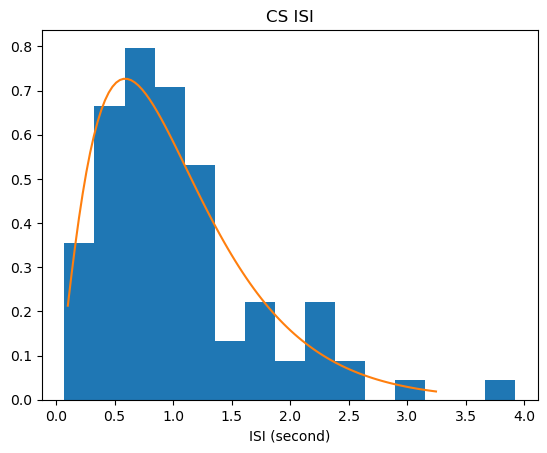

In [5]:
data = loadmat('cs_real\\NU_DRL_002_WB_AP_translations_sscs.mat')
spk_fs = 30000
cplx_spk = np.array(data['cs_idx'])[0,:]

cplx_spk_t = cplx_spk/spk_fs
cplx_spk_ISI = np.diff(cplx_spk_t)

# fix double-counting (ISI should not be 0)
cplx_spk_ISI = cplx_spk_ISI[cplx_spk_ISI>0]

plt.hist(cplx_spk_ISI,bins=15,density=True)

# fixing location at 0
cs_fit_alpha, cs_fit_loc, cs_fit_beta=stats.gamma.fit(cplx_spk_ISI,floc=0.0)

x = np.linspace(stats.gamma.ppf(0.01, cs_fit_alpha, cs_fit_loc, cs_fit_beta), stats.gamma.ppf(0.99, cs_fit_alpha, cs_fit_loc, cs_fit_beta),100)
plt.plot(x, stats.gamma.pdf(x, cs_fit_alpha, cs_fit_loc, cs_fit_beta))

plt.xlabel('ISI (second)')
plt.title('CS ISI')

print('done')


Similarly, to determine a parallel fiber current input train
- calculate statisitics from real simple spike train and fit poisson/gamma process
- generate simulated poisson/gamma process

done


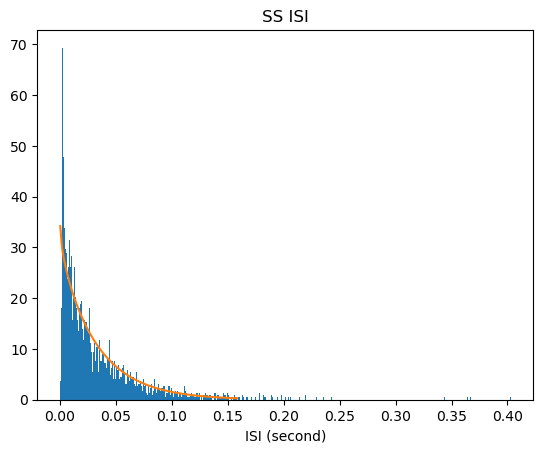

In [6]:
s_spk = np.array(data['ss_idx'])[0,:]

s_spk_t = s_spk/spk_fs
s_spk_ISI = np.diff(s_spk_t)

plt.hist(s_spk_ISI,bins=500,density=True)

# fixing location at 0
ss_fit_alpha, ss_fit_loc, ss_fit_beta=stats.gamma.fit(s_spk_ISI,floc=0.0)

x = np.linspace(stats.gamma.ppf(0.01, ss_fit_alpha, ss_fit_loc, ss_fit_beta), stats.gamma.ppf(0.99, ss_fit_alpha, ss_fit_loc, ss_fit_beta),100)
plt.plot(x, stats.gamma.pdf(x, ss_fit_alpha, ss_fit_loc, ss_fit_beta))

plt.xlabel('ISI (second)')
plt.title('SS ISI')

print('done')

In [7]:
# now resample CS ISI from gamma distribution
sim_cs_N = 10
sim_cs_ISI = [stats.gamma.rvs(cs_fit_alpha, loc=cs_fit_loc, scale=cs_fit_beta) for i in range(sim_cs_N)] 

# and take into cs params
cf_current_value = np.random.normal(100, 30, size=(sim_cs_N,))
cs_times = np.cumsum(sim_cs_ISI)
cf_a = cf_current_value*uA
cs_duration=100*ms

background_current = 65*uA

In [8]:
# now resample SS ISI from gamma distribution
sim_ss_N = 100
sim_ss_ISI = [stats.gamma.rvs(ss_fit_alpha, loc=ss_fit_loc, scale=ss_fit_beta) for i in range(sim_ss_N)] 

# and take into ss params
pf_current_value = np.random.normal(5, 2, size=(sim_ss_N,))
ss_times = np.cumsum(sim_ss_ISI) + 0.2
pf_a = pf_current_value*uA
ss_duration=30*ms

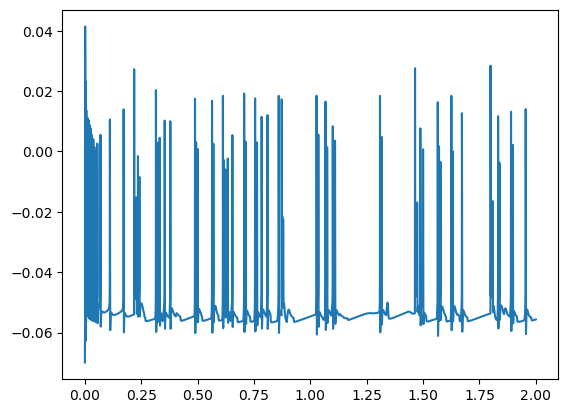

In [9]:
# run the model
i_e=Electrode(cs_times,cs_duration,cf_a,ss_times,ss_duration,pf_a,background_current)

somatic_voltage=Somatic_voltage(c_soma,g_rna,g_k,g_sk,g_ca,g_leak,e_na,e_k,e_ca,e_leak,i_e,v_initial)
f=All_derivatives(somatic_voltage,rna_states,rate_k,rate_sk,rate_ca,rate_ca_concentration)
rna_y_initial=[rna_states.c1_initial,rna_states.c2_initial,0,0,0,0,0,0,0,0,0,0,0]
y_initial=[somatic_voltage.v_initial,0]+rna_y_initial+[0,0,baseline_calcium_concentration]

t0=0
t1=t_run

integrator = ode(f).set_integrator('vode', method='bdf', with_jacobian=False)
integrator.set_initial_value(y_initial, t0)

norm_n=10
print_n=100
norm_c=1
print_c=1

time_base = []
voltage_trace = []
while integrator.successful() and integrator.t < t1:
    integrator.integrate(integrator.t+dt)

    if norm_c==1:
        y=integrator.y
        y=normalize(y)
        integrator.set_initial_value(y,integrator.t)
        norm_c=norm_n
    if print_c==1:
        print_c=print_n
        time_base.append(integrator.t)
        voltage_trace.append(integrator.y[0])
    norm_c-=1
    print_c-=1

# plot the complex spike
time_base = np.array(time_base)
voltage_trace = np.array(voltage_trace)

plt.plot(time_base,voltage_trace)

In [10]:
print('debug')

%matplotlib tk
plt.plot(time_base,voltage_trace)

debug
